In [1]:
import cv2 as cv
import numpy as np
import matplotlib as plt
import os
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
#from tqdm import tqdm

In [2]:
def load_labels(image_paths, categories):
    images = []
    labels = []

    for cat in categories:
        for image_path in image_paths[cat]:
            image = cv.imread(image_path)
            grayscale = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
            images.append(grayscale)
            labels.append(cat)
    return images,labels
#-------------------------------------------------------------------------------
def extract_sift_features(images):
    sift = cv.SIFT_create()
    keypoints,descriptors = [],[]

    for image in images:
        kp,desc = sift.detectAndCompute(image,None)
        keypoints.append(kp)
        if desc is not None: descriptors.append(desc)
#         print('added desc')
    #descriptors = np.asarray(descriptors)
    return keypoints,descriptors
#-------------------------------------------------------------------------------
def build_vocab(descriptors,K):
    kmeans = KMeans(n_clusters=K)
    #print(descriptors.shape)
    kmeans.fit(descriptors)
    return kmeans
#-------------------------------------------------------------------------------
def extract_bovw_features(images,keypoints,vocab):
    bovw_features = []

    for i,image in enumerate(images):
        kp,desc = keypoints[i],None
        if len(kp) >0:
            desc = vocab.predict(descriptors)
        hist,_ = np.histogram(desc,bins=np.arange(vocab.n_clusters+1))
        bovw_features.append(hist)
    return bovw_features
#-------------------------------------------------------------------------------
def train(bovw_features,labels):
    X_train,X_test,y_train,y_test = train_test_split(bovw_features,labels,test_size=0.2)
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    svm = SVC(kernel='linear',C=1)
    svm.fit(X_train,y_train)
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)

    return svm,scaler,accuracy
#-------------------------------------------------------------------------------
path1 = './images/hotdog/'
path2 = './images/notdog/'
hotdogs,notdogs = [],[]
for img in os.listdir(path1): hotdogs.append(path1+img)
for img in os.listdir(path2): notdogs.append(path2+img)


image_paths = {0:hotdogs,1:notdogs}
categories = list(image_paths.keys())

images, labels = load_labels(image_paths,categories)


In [3]:
keypoints,descriptors = extract_sift_features(images=images)

In [14]:
def load_images_from_folder(folder):
    images = {}
    for filename in os.listdir(folder):
        category = []
        if filename != '.DS_Store':
            path = folder + "/" + filename
            for cat in os.listdir(path):
                img = cv.imread(path + "/" + cat,0)

                if img is not None:
                    category.append(img)
        images[filename] = category
    return images

images = load_images_from_folder('./images')
test = load_images_from_folder('./test')

def sift_features(images):
    sift_vectors = {}
    descriptor_list = []
    sift = cv.SIFT_create()
    for key,value in images.items():
        features = []
        for img in value:
            kp, des = sift.detectAndCompute(img,None)

            descriptor_list.extend(des)
            features.append(des)
        sift_vectors[key] = features
    return [descriptor_list, sift_vectors]

sifts = sift_features(images) 
# Takes the descriptor list which is unordered one
descriptor_list = sifts[0] 
# Takes the sift features that is seperated class by class for train data
all_bovw_feature = sifts[1] 
# Takes the sift features that is seperated class by class for test data
test_bovw_feature = sift_features(test)[1] 



# def extract_bovw_features(images, keypoints, vocab):
#     bovw_features = []
#     sift = cv.SIFT_create()

#     for i, image in enumerate(images):
#         kp, desc = keypoints[i], None
#         if len(kp) > 0:
#             _, desc = sift.compute(image, kp)  # Compute descriptors using SIFT

#         # Create a dictionary to store the descriptor counts
#         descriptor_count = {}
#         for d in desc:
#             descriptor_count[tuple(d)] = descriptor_count.get(tuple(d), 0) + 1

#         # Create a histogram of descriptor counts using the vocabulary clusters
#         hist = np.zeros(vocab.n_clusters)
#         for cluster_index, cluster_center in enumerate(vocab.cluster_centers_):
#             if tuple(cluster_center) in descriptor_count:
#                 hist[cluster_index] = descriptor_count[tuple(cluster_center)]

#         bovw_features.append(hist)

#     return bovw_features

def build_vocab(descriptors, K):
    descriptors_concatenated = np.concatenate(descriptors, axis=0) if len(descriptors) > 0 else np.empty((0,))
    kmeans = KMeans(n_clusters=K)
    kmeans.fit(descriptors_concatenated)
    return kmeans

print(type(descriptors[0]))
visual_vocab = build_vocab(descriptors, K=2)

# bovw_features = extract_bovw_features(images, keypoints, visual_vocab)
svm,scaler,accuracy = train(bovw_features, labels)
print(f'Accuracy: {accuracy}')

<class 'numpy.ndarray'>


/opt/homebrew/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy: 0.490280777537797


In [26]:
# print(f'test type: {type(test_bovw_feature)}')
# print(f'test keys: {test_bovw_feature.keys()}')
# print(len(test_bovw_feature.values()))
# print(test_bovw_feature.values())
for _class, features in test_bovw_feature.items():
    reshaped_features = [arr.flatten() for arr in features]
    all_values = [val for sublist in reshaped_features for val in sublist]
    plt.hist(all_values,bins=50)
    plt.xlabel('values')
    plt.ylabel('freq')
    plt.title('title')
    plt.show()

test type: <class 'dict'>
test keys: dict_keys(['.DS_Store', 'hotdog', 'notdog'])
3
dict_values([[], [array([[ 2.,  9., 12., ...,  2.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  2.],
       [34., 15.,  1., ...,  0.,  0.,  0.],
       ...,
       [ 5.,  1.,  1., ...,  0.,  0.,  1.],
       [ 0.,  0.,  8., ...,  0.,  0.,  6.],
       [38.,  1.,  0., ...,  1.,  0.,  5.]], dtype=float32), array([[ 0.,  0.,  0., ...,  4.,  0.,  0.],
       [13., 21.,  0., ...,  0.,  0.,  0.],
       [17.,  5.,  0., ..., 60., 13.,  8.],
       ...,
       [ 5.,  0.,  0., ...,  0.,  2., 52.],
       [19.,  7.,  2., ...,  0.,  0., 58.],
       [62., 26.,  0., ...,  1., 10., 40.]], dtype=float32), array([[  0.,  23.,  27., ...,  16.,   2.,  11.],
       [132.,  22.,   0., ...,   2.,  14.,  52.],
       [ 28.,  74.,   7., ...,  14.,  13.,   0.],
       ...,
       [ 41.,  10.,   1., ...,   0.,   0.,   0.],
       [  0., 107.,  78., ...,   0.,   0.,   2.],
       [ 16.,  54.,  16., ...,   0.,   0.,   3.]],

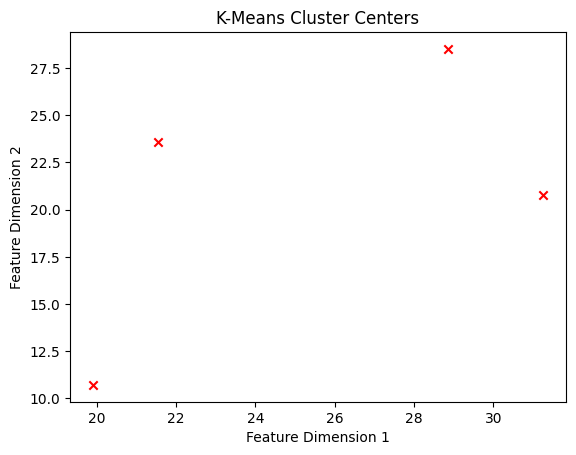

In [15]:
import matplotlib.pyplot as plt
def kmeans(k, descriptor_list):
    kmeans = KMeans(n_clusters = k, n_init=10)
    kmeans.fit(descriptor_list)
    visual_words = kmeans.cluster_centers_ 

    plt.scatter(visual_words[:, 0], visual_words[:, 1], c='red', marker='x')
    plt.xlabel('Feature Dimension 1')
    plt.ylabel('Feature Dimension 2')
    plt.title('K-Means Cluster Centers')
    plt.show()

    return visual_words

# Takes the central points which is visual words    
visual_words = kmeans(4, descriptor_list) 

def find_index(feature, centers):
    distances = np.linalg.norm(centers - feature, axis=1)
    return np.argmin(distances)

def image_class(all_bovw, centers):
    dict_feature = {}
    for key, value in all_bovw.items():
        category = []
        for img in value:
            histogram = np.zeros(len(centers))
            for each_feature in img:
                ind = find_index(each_feature, centers)
                histogram[ind] += 1
            category.append(histogram)
        dict_feature[key] = category
    return dict_feature

# Creates histograms for train data    
bovw_train = image_class(all_bovw_feature, visual_words) 
# Creates histograms for test data
bovw_test = image_class(test_bovw_feature, visual_words) 


In [16]:
from scipy.spatial import distance

def knn(images, tests):
    num_test = 0
    correct_predict = 0
    class_based = {}
    
    for test_key, test_val in tests.items():
        class_based[test_key] = [0, 0] # [correct, all]
        for tst in test_val:
            predict_start = 0
            #print(test_key)
            minimum = 0
            key = "a" #predicted
            for train_key, train_val in images.items():
                for train in train_val:
                    if(predict_start == 0):
                        minimum = distance.euclidean(tst, train)
                        #minimum = L1_dist(tst,train)
                        key = train_key
                        predict_start += 1
                    else:
                        dist = distance.euclidean(tst, train)
                        #dist = L1_dist(tst,train)
                        if(dist < minimum):
                            minimum = dist
                            key = train_key
            
            if(test_key == key):
                correct_predict += 1
                class_based[test_key][0] += 1
            num_test += 1
            class_based[test_key][1] += 1
            #print(minimum)
    return [num_test, correct_predict, class_based]
    
# Call the knn function    

results_bowl = knn(bovw_train, bovw_test) 

In [50]:

# Calculates the average accuracy and class based accuracies.  
def accuracy(results):
    avg_accuracy = 0.0
    class_accuracies = {}

    if results[0] != 0:
        avg_accuracy = (results[1] / results[0]) * 100

    print("Average accuracy: %" + str(avg_accuracy))
    print("\nClass-based accuracies: \n")

    for key, value in results[2].items():
        class_accuracy = 0.0

        if value[1] != 0:
            class_accuracy = (value[0] / value[1]) * 100

        class_accuracies[key] = class_accuracy
        print(key + " : %" + str(class_accuracy))

    return avg_accuracy, class_accuracies
        
# Calculates the accuracies and write the results to the console.       
accuracy(results_bowl) 

Average accuracy: %99.5

Class-based accuracies: 

.DS_Store : %0.0
hotdog : %99.0
notdog : %100.0


(99.5, {'.DS_Store': 0.0, 'hotdog': 99.0, 'notdog': 100.0})

In [51]:
# not_a_hotdog = './images/not-a-hotdog.jpeg'
# img = cv.imread(not_a_hotdog,0)


# sift = cv.SIFT_create()
# # Use descriptor (des)
# kp, des = sift.detectAndCompute(img,None)
# test_bovw_feature = des

# bovw_test = image_class(test_bovw_feature, visual_words) 
